# Part 1 - Lung Image Segmentation

## TensorFlow Add-ons Installation

To ensure that we have the latest version of TensorFlow Add-ons available, which might include useful functionalities not present in the core TensorFlow package.

In [1]:
!pip install -U tensorflow-addons

  Obtaining dependency information for tensorflow-addons from https://files.pythonhosted.org/packages/c0/a0/2bb2edb863555eb87e8ed45ded678138f454743a6ee90e0ee994f00a7147/tensorflow_addons-0.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.22.0
    Uninstalling tensorflow-addons-0.22.0:
      Successfully uninstalled tensorflow-addons-0.22.0


## Import necessary libraries

In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Lung segmentation from Chest X-Ray dataset

**About the data**:
- The dataset is made up of images and segmentated mask from two diffrent sources.
- There is a slight abnormality in naming convention of masks.
- Some images don't have their corresponding masks.
- Images from the Shenzhen dataset has apparently smaller lungs as compared to the Montgomery dataset.

## Dataset Paths and Preprocessing Function
This section of the code specifies the paths to the dataset directories for different categories of chest X-ray images and their corresponding masks.

#### Function: `getData`
- **Purpose**: To load and preprocess the images from specified paths.
- **Process**:
  - The function iterates through the files in the dataset, ensuring only files that have a corresponding mask are processed.
  - Each image and its mask are resized to the specified dimensions and converted to grayscale (single channel), then added to their respective lists.
  - The function stops processing if the specified limit is reached.

#### Data Loading and Preprocessing
- We set the dimension of images to 256x256 pixels.
- We call `getData` for each category, loading and preprocessing the images and masks.
- After loading, the data is converted into NumPy arrays and reshaped to fit the model's input requirements.

#### Data Concatenation
- Finally, we concatenate the arrays from all categories to create a comprehensive dataset for training and validation.
- The shapes of the final datasets are printed to verify the successful preparation of the data.

In [3]:
# Specify the paths for the new dataset
covid_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
covid_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks"
lung_opacity_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lung_opacity_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks"
normal_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
normal_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks"
viral_pneumonia_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
viral_pneumonia_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"

# Define a function to load and preprocess the new dataset
def getData(dataset_path, mask_path, X_shape, limit=1346):
    im_array = []
    mask_array = []

    dataset_files = set(os.listdir(dataset_path)) & set(os.listdir(mask_path))

    for i in tqdm(dataset_files):
        im = cv2.resize(cv2.imread(os.path.join(dataset_path, i)), (X_shape, X_shape))[:,:,0]
        mask = cv2.resize(cv2.imread(os.path.join(mask_path, i)), (X_shape, X_shape))[:,:,0]

        im_array.append(im)
        mask_array.append(mask)

        # Check if the limit is reached for each class
        if len(im_array) >= limit:
            break

    return im_array, mask_array

# Load and preprocess each category of the new dataset
dim = 256
X_covid, y_covid = getData(covid_path, covid_mask_path, dim)
X_lung_opacity, y_lung_opacity = getData(lung_opacity_path, lung_opacity_mask_path, dim)
X_normal, y_normal = getData(normal_path, normal_mask_path, dim)
X_viral_pneumonia, y_viral_pneumonia = getData(viral_pneumonia_path, viral_pneumonia_mask_path, dim)

# Convert lists to numpy arrays
X_covid = np.array(X_covid).reshape(len(X_covid), dim, dim, 1)
y_covid = np.array(y_covid).reshape(len(y_covid), dim, dim, 1)
X_lung_opacity = np.array(X_lung_opacity).reshape(len(X_lung_opacity), dim, dim, 1)
y_lung_opacity = np.array(y_lung_opacity).reshape(len(y_lung_opacity), dim, dim, 1)
X_normal = np.array(X_normal).reshape(len(X_normal), dim, dim, 1)
y_normal = np.array(y_normal).reshape(len(y_normal), dim, dim, 1)
X_viral_pneumonia = np.array(X_viral_pneumonia).reshape(len(X_viral_pneumonia), dim, dim, 1)
y_viral_pneumonia = np.array(y_viral_pneumonia).reshape(len(y_viral_pneumonia), dim, dim, 1)

# Concatenate data from all categories
X_data = np.concatenate((X_covid, X_lung_opacity, X_normal, X_viral_pneumonia), axis=0)
y_data = np.concatenate((y_covid, y_lung_opacity, y_normal, y_viral_pneumonia), axis=0)

# Print shapes of the concatenated datasets
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)


100%|██████████| 1345/1345 [00:26<00:00, 51.08it/s]


X_data shape: (5383, 256, 256, 1)
y_data shape: (5383, 256, 256, 1)


- The `plotMask` function is designed to visually inspect the preprocessing results of the chest X-ray images alongside their corresponding masks. This visual check is crucial to ensure that the image resizing and mask application are correctly aligned and that the data is suitable for feeding into the deep learning model.

In [4]:
#perform sanity check
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i],cmap="gray")
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1],cmap="gray")
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2],cmap="gray")
        
        plt.show()

### Visual Inspection of Preprocessed Datasets
This code block is designed to view the preprocessed datasets for different categories of chest X-rays: COVID-19, Normal, Lung Opacity, and Viral Pneumonia. By displaying a few samples from each set, we ensure that the images and their corresponding masks are correctly processed and aligned.

Covid set


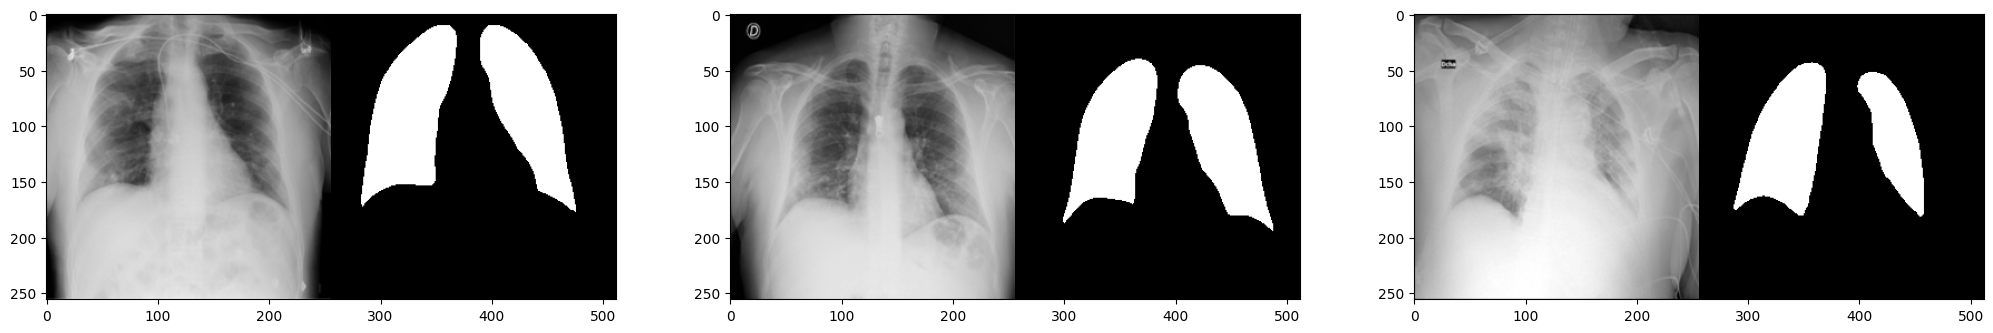

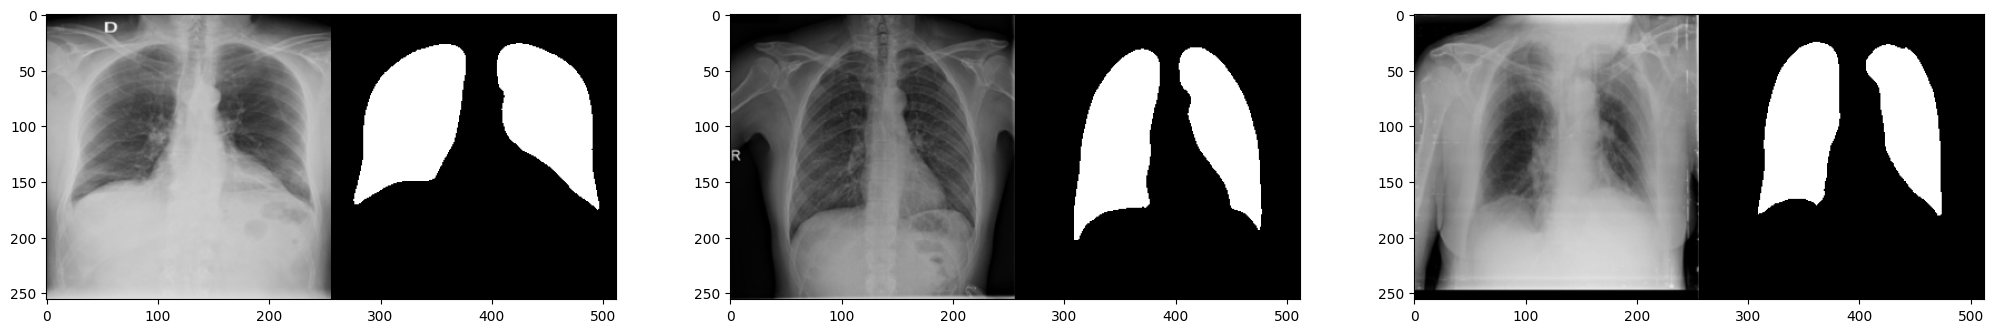

Normal set


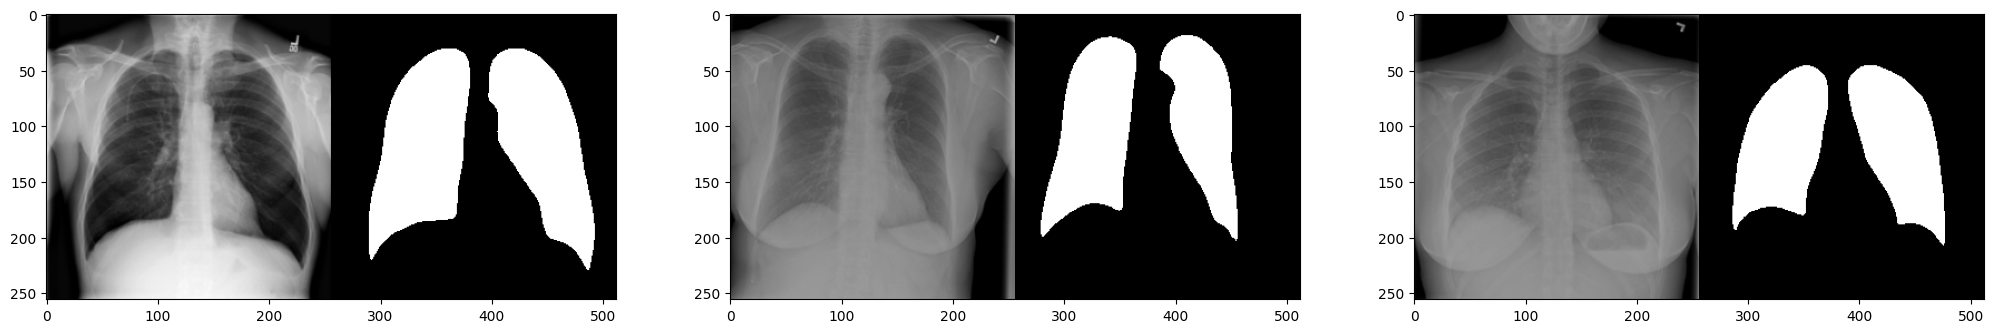

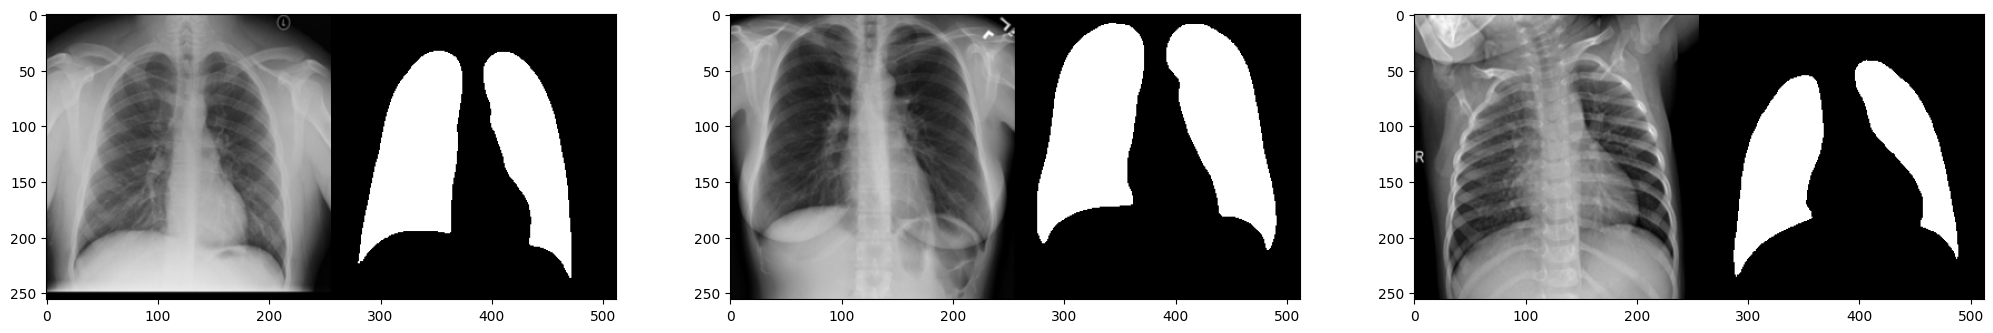

Lung Opacity set


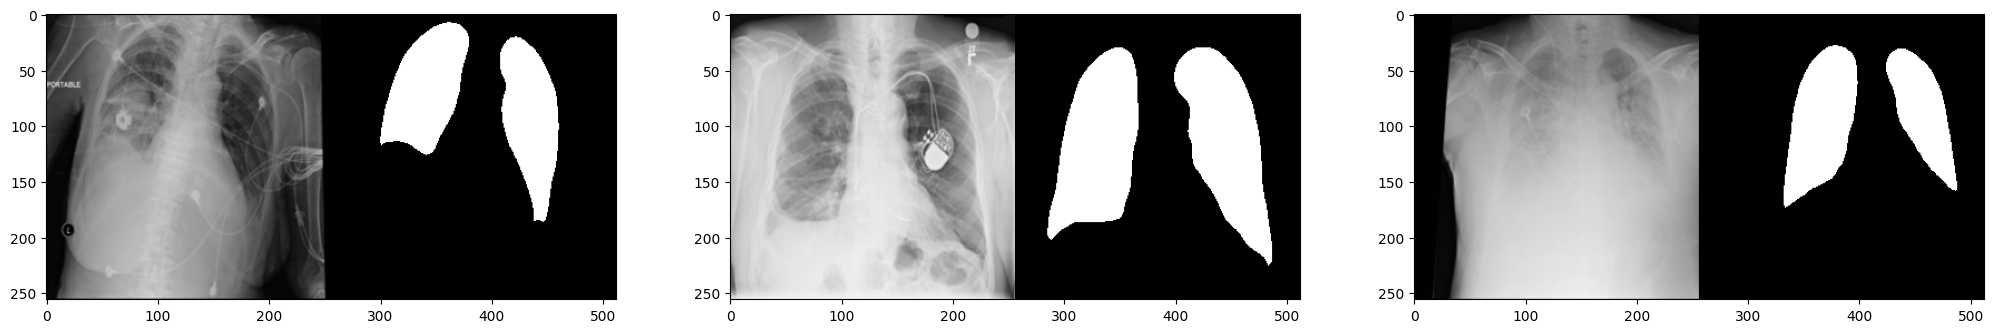

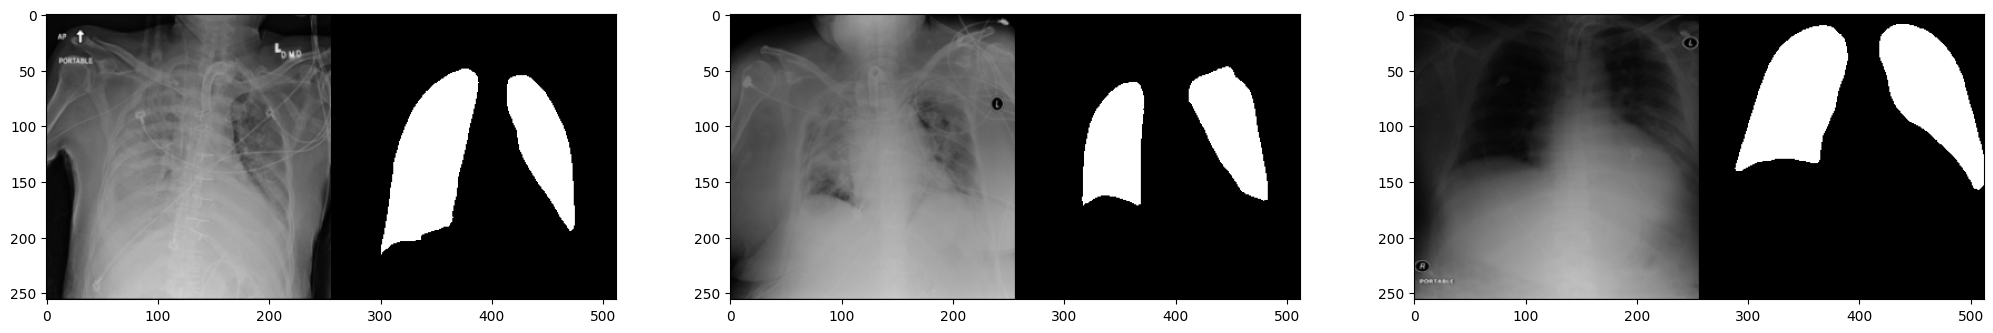

Viral Pneumonia set


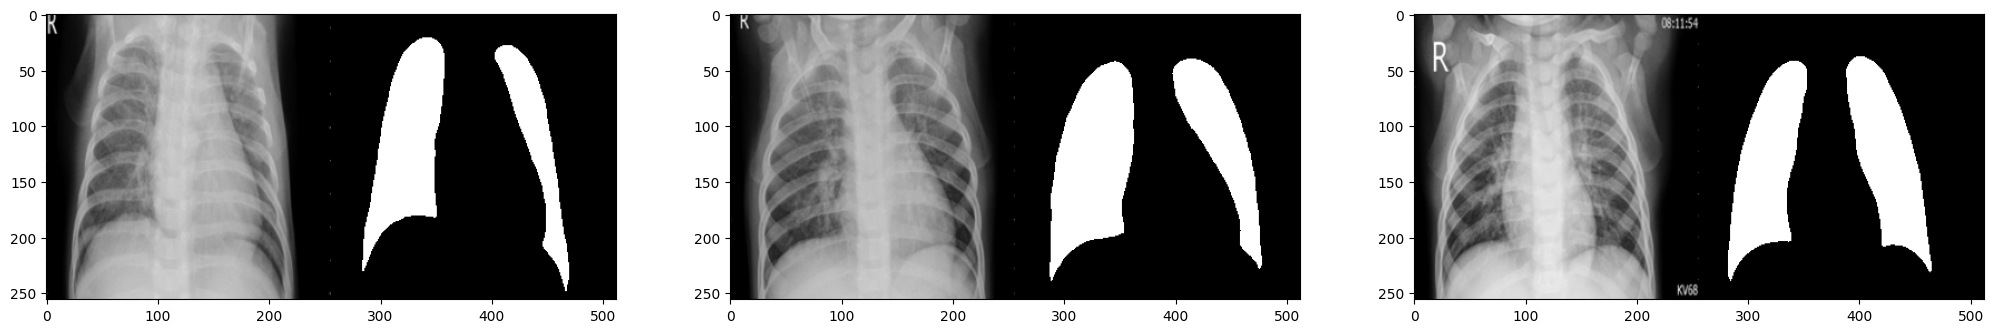

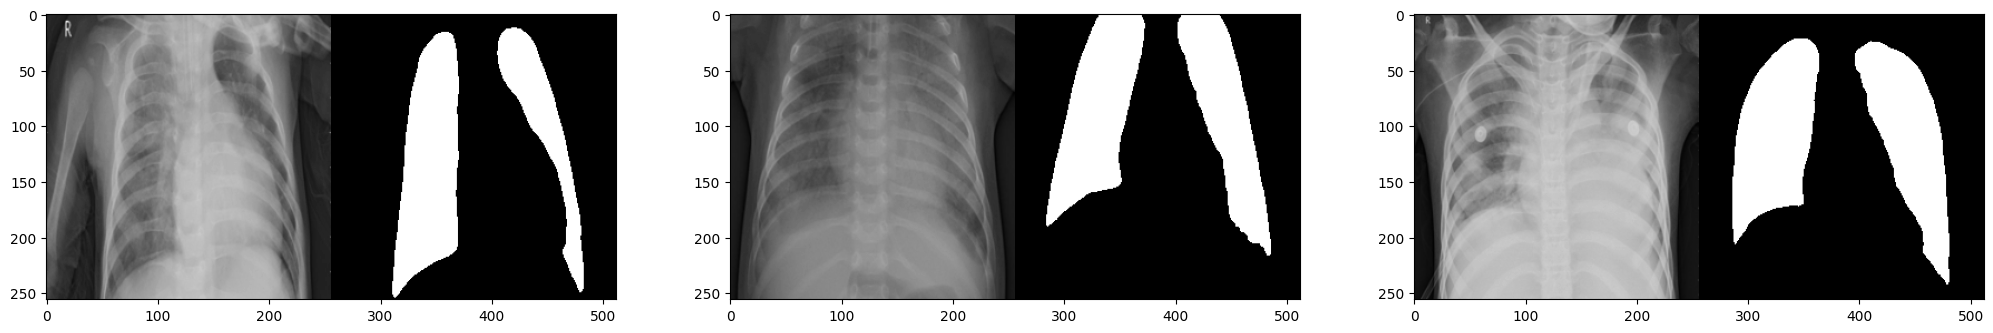

In [5]:
print("Covid set")
plotMask(X_covid,y_covid)
print("Normal set")
plotMask(X_normal,y_normal)
print("Lung Opacity set")
plotMask(X_lung_opacity,y_lung_opacity)
print("Viral Pneumonia set")
plotMask(X_viral_pneumonia,y_viral_pneumonia)

## Model Setup with Segmentation-Models Library
In this section, we install and configure the `segmentation-models` library, a specialized library for semantic segmentation tasks with deep learning models. We then proceed to initialize our model using a pre-defined architecture from this library.

- **Model Choice**: We choose the `Unet` model combined with the `InceptionResNetV2` backbone. Unet is renowned for its efficiency in medical image segmentation due to its architecture that efficiently captures spatial hierarchies for pixel-level predictions.
- We simultaneously tested with other combinations of models and backbones before choosing Unet as the best model with InceptionResNetV2 as the backbone.
- **Parameters**:
  - `classes=1`: Indicates binary segmentation (presence or absence of disease).
  - `activation='sigmoid'`: Suitable for binary classification tasks.
  - `input_shape=(256, 256, 1)`: Matches the preprocessing size of our images, indicating grayscale input.
  - `encoder_weights=None`: We do not use pre-trained weights as our focus is on training a model specifically tailored to the unique characteristics of lung X-rays in our dataset.

In [6]:
!pip install -U -q segmentation-models

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
model = sm.Unet('inceptionresnetv2', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)

Segmentation Models: using `tf.keras` framework.


### Model Optimization and Callbacks Setup
In this section, we set up various components and callbacks to optimize the training process of our model. These components include optimization algorithms, model checkpointing, and learning rate adjustments, which are crucial for efficient and effective model training.

#### Callbacks Explanation:
1. **ModelCheckpoint**:
   - **Purpose**: Saves the model after every epoch if there is an improvement in validation loss.
   - **Parameters**:
     - `weight_path`: Specifies the file path where the model weights are saved.
     - `monitor='val_loss'`: Monitors the validation loss for improvements.
     - `save_best_only=True`: Ensures that only the best model weights are saved.
     - `mode='min'`: Aims to minimize the validation loss.
     - `save_weights_only=True`: Saves only the weights of the model, not the full model.
  
2. **ReduceLROnPlateau**:
   - **Purpose**: Reduces the learning rate when the validation loss plateaus, helping to fine-tune the model by taking smaller steps.
   - **Parameters**:
     - `factor=0.5`: The factor by which the learning rate is reduced.
     - `patience=4`: Number of epochs with no improvement after which learning rate will be reduced.
     - `min_lr=1e-6`: The lower bound of the learning rate.
  
3. **EarlyStopping**:
   - **Purpose**: Stops training early if the validation loss does not improve for a specified number of epochs.
   - **Parameters**:
     - `patience=25`: Number of epochs to wait before stopping after seeing no improvement.

#### Optimization Strategy
- The combination of these callbacks ensures that the model does not overfit, optimizes its performance on the validation data, and stops training at an appropriate time to save computational resources.

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="inceptionresnetv2.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min',save_weights_only=True)



reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=25) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [early, reduceLROnPlat,checkpoint]

### Data Splitting for Model Training, Validation, and Testing
In this segment, we utilize the `train_test_split` function from Scikit-learn to partition our dataset into training, validation, and test sets. This step is crucial for evaluating the model's performance accurately and ensuring that it generalizes well to unseen data.

#### Splitting Strategy:
1. **First Split**:
   - **Purpose**: To divide the data into initial training and validation sets.
   - **Normalization**: The pixel values of X-ray images (`X_data`) are normalized by subtracting 127.0 and then dividing by 127.0 to scale the values between -1 and 1, enhancing the model's learning efficiency.
   - **Binarization**: The mask data (`y_data`) is binarized where pixels greater than 127 are set to 1 (indicating presence of the region of interest), and others set to 0, making it suitable for binary classification tasks.
   - **Parameters**:
     - `test_size=0.1`: 10% of the data is reserved for the validation set.
     - `random_state=2018`: Ensures reproducibility of the results by using a fixed seed for random operations.

2. **Second Split**:
   - **Purpose**: Further split the training data from the first split into new training and test sets.
   - **Parameters**:
     - `test_size=0.1`: 10% of the remaining training data is set aside as the test set, providing a final check on the model's performance post-training.
     - `random_state=2018`: Same seed as the first split to maintain consistency in data splitting.


In [8]:
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split((X_data-127.0)/127.0, 
                                                            (y_data>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)


train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

### Custom Metrics for Model Evaluation
In this section, we define custom metrics for evaluating the performance of our segmentation model. These metrics, Dice Coefficient and Intersection over Union (IoU), are particularly useful for assessing the quality of segmentation in medical imaging tasks.

#### Dice Coefficient
- Measures the similarity between the predicted segmentation and the ground truth mask. It is especially useful in the context of binary segmentation tasks.

#### Dice Loss
- Used as a loss function for training the model; it's particularly effective for data with imbalanced classes.

#### Intersection over Union (IoU)
- Another standard metric for evaluating object detection and segmentation models. It measures the overlap between the predicted segmentation and the ground truth.

In [9]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

### Model Compilation
The model compilation step involves specifying the optimizer, loss function, and metrics used to gauge the model's performance. This configuration is crucial for training the model effectively.

#### Components:
1. **Optimizer**:
   - **Type**: Adam Optimizer
   - **Learning Rate**: `1e-4`

2. **Loss Function**:
   - **Type**: `dice_coef_loss`
   - A custom loss function based on the Dice Coefficient, which is effective for segmentation tasks where the classes are imbalanced.

3. **Metrics**:
   - **Dice Coefficient**: As defined earlier, it quantifies the similarity between the predicted and actual segmentation masks, which is directly related to the segmentation's accuracy.
   - **Binary Accuracy**: Measures the accuracy of the model predictions, indicating the percentage of correctly predicted pixels as either foreground or background.
   - **IoU Score**: Intersection over Union, another critical metric for segmentation tasks, quantifying the overlap between the predicted mask and the true mask.

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])


### Model Training Process

#### Key Components:
1. **Training Data**:
   - `train_vol`: The input training volume data consisting of normalized chest X-ray images.
   - `train_seg`: The corresponding segmentation masks for the training images.

2. **Batch Size**:
   - Set to 32.

3. **Epochs**:
   - The model will undergo 50 epochs of training, allowing sufficient iterations for the model to learn the complex patterns in the data without overfitting.

4. **Validation Data**:
   - `(test_vol, test_seg)`: While named test, this set is used here as validation data to monitor the model's performance and prevent overfitting during training.

5. **Callbacks**:
   - `callbacks_list`: Includes early stopping, reduce learning rate on plateau, and model checkpointing. These are used to fine-tune the training process.

In [11]:
from IPython.display import clear_output
#tf.config.run_functions_eagerly(True)

loss_history = model.fit(x = train_vol, 
                       y = train_seg,
                         batch_size = 32,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/50
137/137 [==============================] - ETA: 0s - loss: 0.3146 - dice_coef: 0.6860 - binary_accuracy: 0.9135 - iou_score: 0.8563
Epoch 1: val_loss improved from inf to 0.65265, saving model to inceptionresnetv2.weights.h5
137/137 [==============================] - 199s 715ms/step - loss: 0.3146 - dice_coef: 0.6860 - binary_accuracy: 0.9135 - iou_score: 0.8563 - val_loss: 0.6527 - val_dice_coef: 0.3454 - val_binary_accuracy: 0.7316 - val_iou_score: 0.7428 - lr: 1.0000e-04
Epoch 2/50
137/137 [==============================] - ETA: 0s - loss: 0.1464 - dice_coef: 0.8537 - binary_accuracy: 0.9754 - iou_score: 0.9389
Epoch 2: val_loss improved from 0.65265 to 0.27989, saving model to inceptionresnetv2.weights.h5
137/137 [==============================] - 90s 654ms/step - loss: 0.1464 - dice_coef: 0.8537 - binary_accuracy: 0.9754 - iou_score: 0.9389 - val_loss: 0.2799 - val_dice_coef: 0.7162 - val_binary_accuracy: 0.9146 - val_iou_score: 0.8893 - lr: 1.0000e-04
Epoch 3/50
137/13

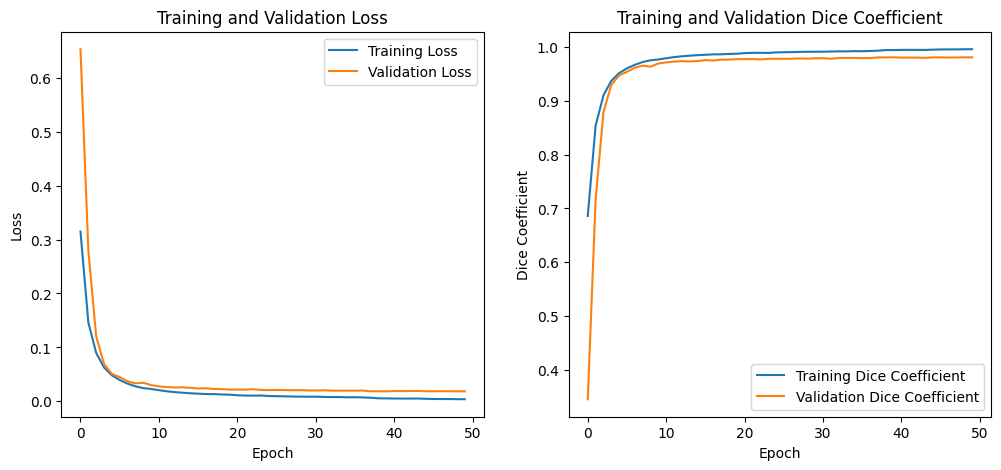

In [14]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_history.history['loss'], label='Training Loss')
plt.plot(loss_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation Dice Coefficient
plt.subplot(1, 2, 2)
plt.plot(loss_history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(loss_history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.show()